In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SAB.csv to SAB.csv


In [ ]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
df = pd.read_csv('SAB.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,3/1/2019,"242,000","236,300","246,000","236,300",31.25K,0.83%
1,3/4/2019,"242,000","240,000","245,500","239,000",44.09K,0.00%
2,3/5/2019,"243,500","244,500","244,800","240,100",10.22K,0.62%
3,3/6/2019,"243,900","240,400","245,000","240,000",22.91K,0.16%
4,3/7/2019,"241,100","242,000","242,900","240,500",25.34K,-1.15%
...,...,...,...,...,...,...,...
1310,5/29/2024,"60,500","61,000","61,300","60,300",1.47M,-0.82%
1311,5/30/2024,"59,300","59,600","60,000","58,300",1.67M,-1.98%
1312,5/31/2024,"58,300","59,300","59,300","58,300",1.49M,-1.69%
1313,6/3/2024,"59,400","59,000","60,100","58,700",1.13M,1.89%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1315 non-null   object
 1   Price     1315 non-null   object
 2   Open      1315 non-null   object
 3   High      1315 non-null   object
 4   Low       1315 non-null   object
 5   Vol.      1315 non-null   object
 6   Change %  1315 non-null   object
dtypes: object(7)
memory usage: 72.0+ KB


<h1> Tien xu ly du lieu

In [ ]:
df = df.dropna() # Drop missing values
df['Date'] = pd.to_datetime(df['Date'])
df["Price"] = df["Price"].str.replace(',', '').astype(float)

In [ ]:
df1 = df.reset_index()['Price']

In [ ]:
df['Index'] = np.arange(len(df.index))

<h1> Scale du lieu

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1>Split the data into training, testing, and validation sets (7:2:1)

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

In [ ]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset

In [ ]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 105ms/step - loss: 0.1969 - val_loss: 0.0225
Epoch 2/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0246 - val_loss: 0.0731
Epoch 3/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0141 - val_loss: 0.0269
Epoch 4/100
13/13 [==============================] - 1s 95ms/step - loss: 0.0106 - val_loss: 0.0272
Epoch 5/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0072 - val_loss: 0.0230
Epoch 6/100
13/13 [==============================] - 1s 95ms/step - loss: 0.0053 - val_loss: 0.0132
Epoch 7/100
13/13 [==============================] - 1s 74ms/step - loss: 0.0035 - val_loss: 0.0087
Epoch 8/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 9/100
13/13 [==============================] - 1s 71ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
13/13 [==============================] - 1s 67ms/step - loss: 9.9025e-04 - val_loss: 5

<h1> Du bao du lieu test, val

In [ ]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 45ms/step


In [ ]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[89661.],
       [89467.],
       [89322.],
       [87533.],
       [86082.],
       [85357.],
       [85550.],
       [85598.],
       [85405.],
       [84631.],
       [82697.],
       [81971.],
       [80762.],
       [79311.],
       [80182.],
       [82407.],
       [82455.],
       [82455.],
       [82745.],
       [82697.],
       [82697.],
       [84148.],
       [83180.],
       [80569.],
       [80037.],
       [80520.],
       [79843.],
       [79892.],
       [79553.],
       [79263.],
       [79360.],
       [78828.],
       [78586.],
       [78489.],
       [77716.],
       [77716.],
       [76893.],
       [76652.],
       [76410.],
       [75201.],
       [75104.],
       [75443.],
       [76410.],
       [76507.],
       [76410.],
       [77087.],
       [77377.],
       [77280.],
       [77280.],
       [77134.],
       [79087.],
       [78989.],
       [79087.],
       [77622.],
       [75669.],
       [76548.],
       [75816.],
       [75669.],
       [75572.

In [ ]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[54800.],
       [54000.],
       [52500.],
       [53200.],
       [53000.],
       [53600.],
       [54400.],
       [54400.],
       [56600.],
       [56700.],
       [57000.],
       [57700.],
       [58900.],
       [57600.],
       [57600.],
       [56900.],
       [57100.],
       [57600.],
       [57500.],
       [58100.],
       [57800.],
       [58000.],
       [57500.],
       [59500.],
       [58000.],
       [58500.],
       [61000.],
       [60500.],
       [59300.],
       [58300.],
       [59400.]])

<h1>
Evaluate the accuracy of the algorithm

In [ ]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 1645.3651541512759
Testing RMSE: 2162.370570172153
Validation MAE: 1407.0541834677417
Testing MAE: 1769.1650752314815
Validation MAPE: 2.491809471898582
Testing MAPE: 2.4258049233835854


<h1>Du doan co phieu trong 30, 60, 90 ngay tiep theo

In [ ]:
x_input=val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.04016913 0.04186047 0.0397463  0.04059197 0.0384778  0.03509514
 0.03763214 0.03636364 0.03340381 0.03340381 0.03340381 0.03382664
 0.03763214 0.03551797 0.03298097 0.03298097 0.02663848 0.02029598
 0.02283298 0.01987315 0.01606765 0.02114165 0.01902748 0.01902748
 0.02029598 0.02241015 0.02494715 0.02325581 0.02283298 0.02579281
 0.02367865 0.02325581 0.01902748 0.01733615 0.01606765 0.02198732
 0.02536998 0.02579281 0.02452431 0.02706131 0.0372093  0.03424947
 0.03171247 0.02875264 0.02790698 0.03002114 0.02621564 0.02325581
 0.01775899 0.01860465 0.01860465 0.01987315 0.02029598 0.01902748
 0.01860465 0.02114165 0.01987315 0.01775899 0.01818182 0.01649049
 0.01479915 0.01691332 0.01522199 0.01183932 0.01057082 0.01183932
 0.01226216 0.01479915 0.01057082 0.00972516 0.00634249 0.
 0.00295983 0.00211416 0.00465116 0.00803383 0.00803383 0.01733615
 0.01775899 0.01902748 0.02198732 0.02706131 0.02156448 0.02156448
 0.01860465 0.01945032 0.02156448 0.02114165 0.02367865 0.

In [ ]:
print(scaler.inverse_transform(lst_output))

[[ 61489.63223211]
 [ 62221.35415673]
 [ 62955.78172803]
 [ 63691.4867945 ]
 [ 64427.18569376]
 [ 65161.87581234]
 [ 65894.83294263]
 [ 66625.57692267]
 [ 67353.8011536 ]
 [ 68079.31973785]
 [ 68802.0331189 ]
 [ 69521.8831487 ]
 [ 70238.86101693]
 [ 70952.96848565]
 [ 71664.23198581]
 [ 72372.67971039]
 [ 73078.35747302]
 [ 73781.30403906]
 [ 74481.57579452]
 [ 75179.21679094]
 [ 75874.2851764 ]
 [ 76566.83028862]
 [ 77256.89970329]
 [ 77944.55861673]
 [ 78629.86165285]
 [ 79312.8493391 ]
 [ 79993.5903959 ]
 [ 80672.12887481]
 [ 81348.52468595]
 [ 82022.82011881]
 [ 82695.08741796]
 [ 83365.36534876]
 [ 84033.69796276]
 [ 84700.14869422]
 [ 85364.76335675]
 [ 86027.60186046]
 [ 86688.70297074]
 [ 87348.11954945]
 [ 88005.90445846]
 [ 88662.09646314]
 [ 89316.75547361]
 [ 89969.92025524]
 [ 90621.65071815]
 [ 91271.98915184]
 [ 91920.98136991]
 [ 92568.66261363]
 [ 93215.09631723]
 [ 93860.32477021]
 [ 94504.37968969]
 [ 95147.32803404]
 [ 95789.19799626]
 [ 96430.04948646]
 [ 97069.907

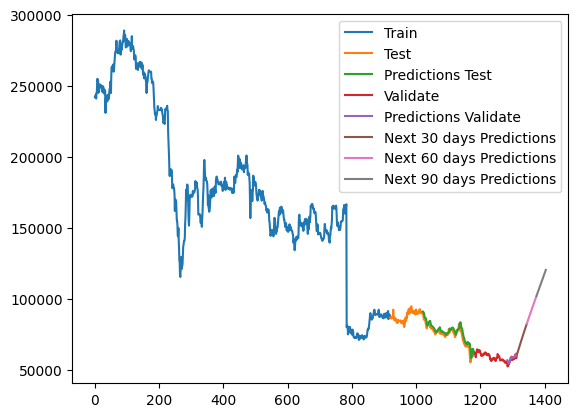

In [ ]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (6:3:1)

In [ ]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [ ]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1>Create dataset

In [ ]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 3s 111ms/step - loss: 0.2428 - val_loss: 0.0104
Epoch 2/100
11/11 [==============================] - 1s 63ms/step - loss: 0.0207 - val_loss: 0.0799
Epoch 3/100
11/11 [==============================] - 1s 64ms/step - loss: 0.0160 - val_loss: 0.0389
Epoch 4/100
11/11 [==============================] - 1s 65ms/step - loss: 0.0078 - val_loss: 0.0260
Epoch 5/100
11/11 [==============================] - 1s 70ms/step - loss: 0.0067 - val_loss: 0.0340
Epoch 6/100
11/11 [==============================] - 1s 63ms/step - loss: 0.0054 - val_loss: 0.0311
Epoch 7/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0046 - val_loss: 0.0240
Epoch 8/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0041 - val_loss: 0.0216
Epoch 9/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0036 - val_loss: 0.0190
Epoch 10/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0031 - val_loss: 0.014

<h1> Du bao du lieu test, val

In [ ]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 47ms/step


In [ ]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[87873.],
       [88916.],
       [89154.],
       [88679.],
       [88679.],
       [87731.],
       [87873.],
       [86782.],
       [86688.],
       [87731.],
       [86403.],
       [89154.],
       [89628.],
       [88110.],
       [88679.],
       [87494.],
       [87020.],
       [87020.],
       [90102.],
       [89343.],
       [87778.],
       [90007.],
       [90529.],
       [90719.],
       [91525.],
       [85834.],
       [89059.],
       [88253.],
       [89106.],
       [88253.],
       [87873.],
       [87067.],
       [87020.],
       [86308.],
       [86308.],
       [87257.],
       [86782.],
       [87494.],
       [87494.],
       [89059.],
       [92473.],
       [88442.],
       [85739.],
       [86782.],
       [84980.],
       [86593.],
       [85929.],
       [86308.],
       [85597.],
       [85360.],
       [83985.],
       [83463.],
       [85360.],
       [83178.],
       [83937.],
       [85218.],
       [84648.],
       [84886.],
       [84411.

In [ ]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[54800.],
       [54000.],
       [52500.],
       [53200.],
       [53000.],
       [53600.],
       [54400.],
       [54400.],
       [56600.],
       [56700.],
       [57000.],
       [57700.],
       [58900.],
       [57600.],
       [57600.],
       [56900.],
       [57100.],
       [57600.],
       [57500.],
       [58100.],
       [57800.],
       [58000.],
       [57500.],
       [59500.],
       [58000.],
       [58500.],
       [61000.],
       [60500.],
       [59300.],
       [58300.],
       [59400.]])

<h1>Evaluate the accuracy of the algorithm

In [ ]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 6547.065117262425
Testing RMSE: 4538.2983566463
Validation MAE: 6454.747101814516
Testing MAE: 4201.763251919795
Validation MAPE: 11.384425597384155
Testing MAPE: 5.400787610319547


<h1>Du doan co phieu trong 30, 60, 90 ngay tiep theo




In [ ]:
x_input=val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.04016913 0.04186047 0.0397463  0.04059197 0.0384778  0.03509514
 0.03763214 0.03636364 0.03340381 0.03340381 0.03340381 0.03382664
 0.03763214 0.03551797 0.03298097 0.03298097 0.02663848 0.02029598
 0.02283298 0.01987315 0.01606765 0.02114165 0.01902748 0.01902748
 0.02029598 0.02241015 0.02494715 0.02325581 0.02283298 0.02579281
 0.02367865 0.02325581 0.01902748 0.01733615 0.01606765 0.02198732
 0.02536998 0.02579281 0.02452431 0.02706131 0.0372093  0.03424947
 0.03171247 0.02875264 0.02790698 0.03002114 0.02621564 0.02325581
 0.01775899 0.01860465 0.01860465 0.01987315 0.02029598 0.01902748
 0.01860465 0.02114165 0.01987315 0.01775899 0.01818182 0.01649049
 0.01479915 0.01691332 0.01522199 0.01183932 0.01057082 0.01183932
 0.01226216 0.01479915 0.01057082 0.00972516 0.00634249 0.
 0.00295983 0.00211416 0.00465116 0.00803383 0.00803383 0.01733615
 0.01775899 0.01902748 0.02198732 0.02706131 0.02156448 0.02156448
 0.01860465 0.01945032 0.02156448 0.02114165 0.02367865 0.

In [ ]:
print(scaler.inverse_transform(lst_output))

[[ 66366.63305573]
 [ 68748.85760248]
 [ 71355.16801849]
 [ 73976.08945519]
 [ 76532.14937821]
 [ 78994.12222207]
 [ 81352.62324288]
 [ 83606.32032156]
 [ 85757.18520582]
 [ 87808.59929323]
 [ 89764.50255513]
 [ 91629.08869982]
 [ 93406.52324259]
 [ 95100.94350576]
 [ 96716.34584665]
 [ 98256.56451285]
 [ 99725.30688345]
 [101126.0547936 ]
 [102462.12092042]
 [103736.72631383]
 [104952.82419026]
 [106113.25499415]
 [107220.75344622]
 [108277.83577144]
 [109286.9477123 ]
 [110250.37994981]
 [111170.28924823]
 [112048.76188934]
 [112887.72909343]
 [113689.07979131]
 [114454.55490053]
 [115185.80371141]
 [115884.44027305]
 [116551.97995901]
 [117189.81832266]
 [117799.32977259]
 [118381.83937967]
 [118938.53124976]
 [119470.59653699]
 [119979.1418165 ]
 [120465.2454704 ]
 [120929.91539836]
 [121374.08901751]
 [121798.70374501]
 [122204.63356376]
 [122592.68902242]
 [122963.68066967]
 [123318.34857166]
 [123657.46098757]
 [123981.66635633]
 [124291.62721336]
 [124587.97085285]
 [124871.317

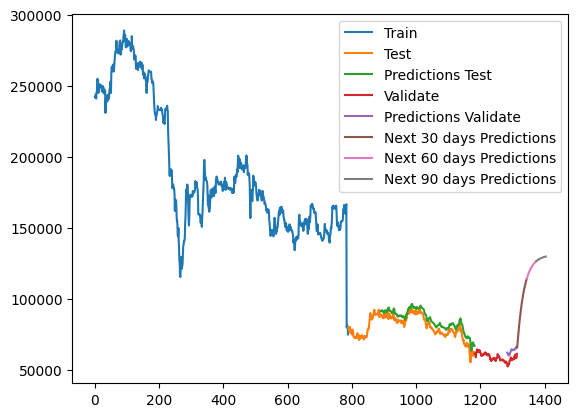

In [ ]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (5:3:2)

In [ ]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [ ]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset

In [ ]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 4s 126ms/step - loss: 0.1638 - val_loss: 0.0100
Epoch 2/100
9/9 [==============================] - 1s 64ms/step - loss: 0.0139 - val_loss: 0.0550
Epoch 3/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0147 - val_loss: 0.0230
Epoch 4/100
9/9 [==============================] - 1s 64ms/step - loss: 0.0049 - val_loss: 0.0128
Epoch 5/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0052 - val_loss: 0.0170
Epoch 6/100
9/9 [==============================] - 1s 65ms/step - loss: 0.0034 - val_loss: 0.0204
Epoch 7/100
9/9 [==============================] - 1s 63ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 8/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0026 - val_loss: 0.0124
Epoch 9/100
9/9 [==============================] - 1s 80ms/step - loss: 0.0023 - val_loss: 0.0122
Epoch 10/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0020 - val_loss: 0.0104
Epoch 11/100
9/9 

<h1>Du bao du lieu test, val

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

6/6 [==============================] - 0s 13ms/step


In [ ]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[153953.],
       [151011.],
       [151011.],
       [148364.],
       [151011.],
       [151011.],
       [148560.],
       [149246.],
       [151011.],
       [154443.],
       [154738.],
       [154443.],
       [154542.],
       [154934.],
       [154836.],
       [155914.],
       [162092.],
       [163269.],
       [162975.],
       [166211.],
       [163269.],
       [161013.],
       [160131.],
       [160327.],
       [163661.],
       [165328.],
       [166701.],
       [ 80096.],
       [ 81566.],
       [ 80475.],
       [ 80760.],
       [ 75117.],
       [ 80143.],
       [ 80143.],
       [ 78246.],
       [ 76871.],
       [ 77535.],
       [ 80333.],
       [ 79432.],
       [ 75923.],
       [ 78199.],
       [ 77535.],
       [ 78199.],
       [ 77156.],
       [ 74832.],
       [ 78484.],
       [ 76587.],
       [ 77251.],
       [ 74216.],
       [ 73077.],
       [ 73030.],
       [ 73030.],
       [ 72556.],
       [ 73030.],
       [ 72746.],
       [ 7

In [ ]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[67858.],
       [67956.],
       [67175.],
       [67175.],
       [66394.],
       [67272.],
       [68444.],
       [69225.],
       [68249.],
       [66687.],
       [66687.],
       [68346.],
       [66198.],
       [67468.],
       [67565.],
       [64636.],
       [61609.],
       [59364.],
       [55361.],
       [56044.],
       [59950.],
       [62391.],
       [64636.],
       [63562.],
       [63562.],
       [62391.],
       [60926.],
       [59852.],
       [60535.],
       [61707.],
       [62683.],
       [62195.],
       [61512.],
       [61609.],
       [62000.],
       [58973.],
       [61512.],
       [62781.],
       [63367.],
       [64636.],
       [63465.],
       [63465.],
       [63172.],
       [62488.],
       [63660.],
       [64050.],
       [64050.],
       [63953.],
       [63465.],
       [62488.],
       [61512.],
       [61317.],
       [60047.],
       [60731.],
       [60535.],
       [60535.],
       [60047.],
       [60535.],
       [61219.

<h1>Evaluate the accuracy of the algorithm

In [ ]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 4457.882115219912
Testing RMSE: 6470.740933165666
Validation MAE: 4259.912121357362
Testing MAE: 3282.86454778157
Validation MAPE: 7.175809067206735
Testing MAPE: 3.883259166169889


<h1>Du doan co phieu trong 30, 60, 90 ngay tiep theo

In [ ]:
x_input=val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 90:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.09734884 0.09590275 0.09507822 0.09528541 0.09507822 0.09548837
 0.09466385 0.08971247 0.08826638 0.08764482 0.08971247 0.09487104
 0.09548837 0.09487104 0.09404651 0.09342495 0.0942537  0.09404651
 0.09796617 0.10416068 0.11158985 0.1087019  0.10209725 0.10168288
 0.1049852  0.10601691 0.11138689 0.10931924 0.11035095 0.11158985
 0.11035095 0.10952643 0.10725581 0.10416068 0.10271459 0.10271459
 0.09941226 0.09507822 0.09321776 0.08764482 0.08785201 0.09487104
 0.10044397 0.10065116 0.10436786 0.10787738 0.10416068 0.10580973
 0.1062241  0.10931924 0.10952643 0.12377167 0.12665962 0.12232558
 0.12975476 0.12108668 0.11158985 0.10416068 0.11035095 0.10828753
 0.1025074  0.0917759  0.08888372 0.08393235 0.07691332 0.07732347
 0.07939112 0.06824101 0.06700211 0.06493869 0.06535307 0.06205074
 0.06205074 0.05874841 0.06246089 0.06741649 0.07071882 0.06659197
 0.05998732 0.05998732 0.06700211 0.05791966 0.06328964 0.06369979
 0.05131501 0.03851586 0.02902326 0.01209725 0.014

In [ ]:
print(scaler.inverse_transform(lst_output))

[[ 64212.68808655]
 [ 65882.55048729]
 [ 67652.80198306]
 [ 69439.26885724]
 [ 71211.54936776]
 [ 72958.44208449]
 [ 74675.62995479]
 [ 76361.40906438]
 [ 78015.22436365]
 [ 79637.06528023]
 [ 81227.22079232]
 [ 82786.1930877 ]
 [ 84314.55307454]
 [ 85812.95800209]
 [ 87282.09155053]
 [ 88722.62330353]
 [ 90135.2686584 ]
 [ 91520.71129531]
 [ 92879.62784618]
 [ 94212.69494295]
 [ 95520.55750042]
 [ 96803.86395752]
 [ 98063.20636719]
 [ 99299.22259599]
 [100512.4694556 ]
 [101703.54252309]
 [102872.96336889]
 [104021.29937708]
 [105149.06154573]
 [106256.7467764 ]
 [107344.8554948 ]
 [108413.84231299]
 [109464.20060843]
 [110496.34975195]
 [111510.726735  ]
 [112507.7791214 ]
 [113487.88046837]
 [114451.43252611]
 [115398.85114133]
 [116330.46758175]
 [117246.68359756]
 [118147.8304565 ]
 [119034.2464745 ]
 [119906.28406405]
 [120764.23925161]
 [121608.4433049 ]
 [122439.17815387]
 [123256.75392151]
 [124061.48073077]
 [124853.60527039]
 [125633.42356682]
 [126401.16821229]
 [127157.128

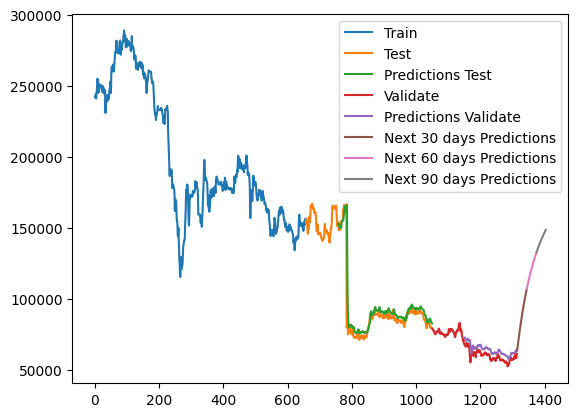

In [ ]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()